## Astronomy 406 "Computational Astrophysics" (Fall 2024)

## Project 4

### Background

In this project we begin exploring model fitting. We will use the same dataset __gc_galaxy.dat__ as in the class notebook, and limit it again to $\log_{10}{L} > 9$.

Fitting linear regression is one of the most common types of statistical analysis you will encounter in the academia or other data research. We will maximize the log-likelihood of data given the linear model with intrinsic scatter:

$$ 2\ln{\cal L}(a,b,\sigma) = -\sum_i \ln{\sigma_i^2} - \sum_i {(y_i - a - b x_i)^2 \over \sigma_i^2} $$

with $\sigma_i^2 \equiv \sigma_{y,i}^2 + b^2 \sigma_{x,i}^2 + \sigma^2$.

### Learning goals

* Practice finding the best-fit parameters of a linear model


* Estimate the uncertainty of model parameters using bootstrap realizations of the data sample. Characterize the shape of the parameter distributions.


* Evaluate confidence limits on the model parameters and present a complete error analysis.

### Task

__Required part:__

1. Write a function for the log-likelihood of the data points and maximize it. Plot the best-fit line and data.<br>

2. Run bootstrap realizations of the sample until the estimation of model parameters converges.  Specifically, accumulate large enough bootstrap distribution that the __standard deviation__ of model parameters $a$, $b$, $\sigma$ __each__ converges to (that is, varies with repeated bootstraps by less than) 0.001. Build the bootstrap realizations in batches between 50 and 100 realizations, for reliable convergence. Note how many realizations each of the parameters required to converge. Which required the largest number? _Note that it is not the same criterion as I used in the class notebook._<br>

3. For each of the three model parameters $p = \{a~{\rm or}~b~{\rm or}~\sigma\}$, plot KDE of the bootstrap values (choose a KDE kernel from those in Project 2 and justify your choice of kernel for these samples). Write a function for a Gaussian distribution density ${\cal N}(p|\mu,\sigma)$ with the mean $\mu$ and standard deviation $\sigma$ estimated for the bootstrap sample of $p$. Overplot this Gaussian distribution on the same plot as the KDE.<br>

4. For each of the three model parameters, use the Kolmogorov-Smirnov test to determine whether the bootstrap samples are consistent with the above Gaussian distributions. What conclusion can you draw from the p-values?<br>

5. Calculate the upper and lower confidence limits $dp_+$ and $dp_-$ for each model parameter $p = \{a,b,\sigma\}$, that is, the range 

$$ p^{+dp_+}_{-dp_-} $$ 

containing a given percentage (confidence level CL) of the bootstrap sample. Write a routine where CL is an argument. Calculate $dp_{\pm}$ for the 68.3% and 90% confidence levels. Compare the 68.3% CL with the standard deviations of the bootstrap sample.

# 1. 
Write a function for the log-likelihood of the data points and maximize it. Plot the best-fit line and data.<br>

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('mplstyle.txt')
from scipy import optimize
import pandas as pd
from scipy import stats

Lgal, dLgal, Mgc, dMgc = np.loadtxt('gc_galaxy.dat', unpack=True)
ind = (Lgal > 9) 
x = Lgal[ind]; dx = dLgal[ind]; y = Mgc[ind]; dy = dMgc[ind];

In [5]:
def neglogLikelihood(p, xb, yb, dxb, dyb):
    a = p[0]
    b = p[1]
    sig = p[2]
    weight = 1. / (sig ** 2 + (b * dxb) ** 2 + dyb ** 2)
    return - np.sum(np.log(weight)) + np.sum(weight * (yb - a - b * xb) ** 2)

In [6]:
o = optimize.minimize(neglogLikelihood, [1.,1.,1.], args=(x, y, dx, dy))

a = o.x[0]
b = o.x[1]
sig = o.x[2]
da = np.sqrt(o.hess_inv[0,0])
db = np.sqrt(o.hess_inv[1,1])
dsig = np.sqrt(o.hess_inv[2,2])
                      
print('a = %.4f +- %.4f  b = %.4f +- %.4f  sig = %.4f +- %.4f'%(a, da, b, db, sig, dsig))

a = -6.7106 +- 0.0001  b = 1.4353 +- 0.0017  sig = 0.3669 +- 0.0140


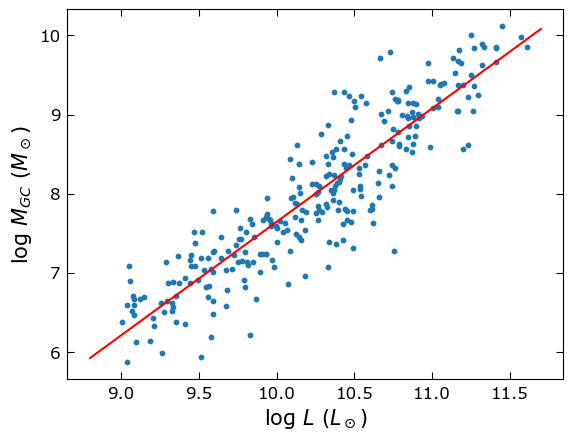

In [7]:
plt.scatter(x, y, s=10)

plt.xlabel(r'log $L \ (L_\odot)$')
plt.ylabel(r'log $M_{GC} \ (M_\odot)$');

xa = np.linspace(8.8, 11.7)
plt.plot(xa, a+b*xa, 'r-')

# 2. 
Run bootstrap realizations of the sample until the estimation of model parameters converges.  Specifically, accumulate large enough bootstrap distribution that the __standard deviation__ of model parameters $a$, $b$, $\sigma$ __each__ converges to (that is, varies with repeated bootstraps by less than) 0.001. Build the bootstrap realizations in batches between 50 and 100 realizations, for reliable convergence. Note how many realizations each of the parameters required to converge. Which required the largest number? _Note that it is not the same criterion as I used in the class notebook._<br>

In [24]:
def bootstrap_batch(batch_size, pboot, iboot):
    for i in range(batch_size):
        iboot += 1
        ir = np.random.randint(low=0, high=len(x), size=len(x))  # random numbers from 0 to N-1
        xb = x[ir]; yb = y[ir]; dxb = dx[ir]; dyb = dy[ir]       # bootstrap sample
        ob = optimize.minimize(neglogLikelihood, [1.,1.,1.], args=(xb, yb, dxb, dyb))
        [pboot[i].append(ob.x[i]) for i in [0,1,2]]

    return pboot, iboot

def convergence_criterion(pmean, pmean_last, epsilon):
    d_list = []
    has_not_converged = []

    # for each parameter, determine if not converged
    for i in range(len(pmean)):
        # d = abs((pmean[i] - pmean_last[i]) / pmean[i])
        d = abs(pmean[i] - pmean_last[i])
    
        if d < epsilon:
            has_not_converged.append(False)
            d_list.append(d)
        else:
            has_not_converged.append(True)
            d_list.append(d)

    return has_not_converged, d_list

In [25]:
np.random.seed(0)

pboot = [[], [], []]     # empty 2D array that will hold all bootstrap parameters

iboot = 0                # counter of bootstrap realizations
a_conv = True
b_conv = True
stdev_conv = True
epsilon = 1e-3
batch_size = 100
pmean = np.array([0, 0, 0])
pstd = np.array([1, 1, 1])

# while each parameter has not converged
while a_conv is True or b_conv is True or stdev_conv is True:

    # Run another batch
    pboot, iboot = bootstrap_batch(batch_size, pboot, iboot)

    # calculate if the parameters have converged
    pmean_last = pmean
    pstd_last = pstd
    pmean = np.array(np.mean(pboot, axis=1))
    pstd = np.std(pboot, axis=1)
    # print(pmean_last, pstd_last)
    has_not_converged, error = convergence_criterion(pstd, pstd_last, epsilon)
    # has_not_converged, error = convergence_criterion(pmean, pmean_last, epsilon)
    print(has_not_converged, iboot)
    a_conv = has_not_converged[0]
    b_conv = has_not_converged[1]
    stdev_conv = has_not_converged[2]

pmean = np.mean(pboot, axis=1) # means of the bootstrap parameter realizations
pstd = np.std(pboot, axis=1)   # standard deviations of the bootstrap parameter realizations

print('iboot = %4d a = %.4f +- %.4f b = %.4f +- %.4f sig = %.4f +- %.4f'\
    %(iboot, pmean[0], pstd[0], pmean[1], pstd[1], pmean[2], pstd[2]))

[True, True, True] 100
[True, True, False] 200
[True, False, False] 300
[True, False, False] 400
[True, False, False] 500
[True, False, False] 600
[True, False, False] 700
[True, False, False] 800
[True, False, False] 900
[True, False, False] 1000
[False, False, False] 1100
iboot = 1100 a = -6.7125 +- 0.3470 b = 1.4355 +- 0.0340 sig = 0.3651 +- 0.0216


The slope took the most realizations to converge, at around 1100 realizations (the intercept took 300 and standard deviation took 200).

# 3. 
For each of the three model parameters $p = \{a~{\rm or}~b~{\rm or}~\sigma\}$, plot KDE of the bootstrap values (choose a KDE kernel from those in Project 2 and justify your choice of kernel for these samples). Write a function for a Gaussian distribution density ${\cal N}(p|\mu,\sigma)$ with the mean $\mu$ and standard deviation $\sigma$ estimated for the bootstrap sample of $p$. Overplot this Gaussian distribution on the same plot as the KDE.<br>

In [10]:
# getting optimal h_0 for each parameter

percentile25 = pd.Series(pboot[0]).quantile(0.25)
percentile75 = pd.Series(pboot[0]).quantile(0.75)
IQR = percentile75 - percentile25
sigma = np.std(pboot[0])
h_0_a = 0.9 * np.min([IQR / 1.34, sigma]) * len(pboot[0]) ** (-1/5)
print('h_0_a:', round(h_0_a, 4))

percentile25 = pd.Series(pboot[1]).quantile(0.25)
percentile75 = pd.Series(pboot[1]).quantile(0.75)
IQR = percentile75 - percentile25
sigma = np.std(pboot[1])
h_0_b = 0.9 * np.min([IQR / 1.34, sigma]) * len(pboot[1]) ** (-1/5)
print('h_0_b:', round(h_0_b, 4))

percentile25 = pd.Series(pboot[2]).quantile(0.25)
percentile75 = pd.Series(pboot[2]).quantile(0.75)
IQR = percentile75 - percentile25
sigma = np.std(pboot[2])
h_0_stdev = 0.9 * np.min([IQR / 1.34, sigma]) * len(pboot[2]) ** (-1/5)
print('h_0_stdev:', round(h_0_stdev, 4))

h_0_a: 0.0603
h_0_b: 0.0059
h_0_stdev: 0.0037


In [11]:
a_x = np.linspace(np.min(pboot[0]), np.max(pboot[0]), 100)
b_x = np.linspace(np.min(pboot[1]), np.max(pboot[1]), 100)
stdev_x = np.linspace(np.min(pboot[2]), np.max(pboot[2]), 100)

In [26]:
# define Epanechnikov kernel
def K_Epan(u):
    if abs(u) <= 1:
        return .75 * (1 - u ** 2)
    else:
        return 0

def KDE_Epan_h(x, h, data):
    sum = 0
    N = len(data) 
    # sum over all data points
    for i in range(len(data)):
        sum += K_Epan((x - data[i]) / h) / h
    return sum / N

In [36]:
# function for Gaussian distribution
def gaussian(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

a_mu = np.mean(pboot[0])
b_mu = np.mean(pboot[1])
stdev_mu = np.mean(pboot[2])

a_sigma = np.std(pboot[0])
b_sigma = np.std(pboot[1])
stdev_sigma = np.std(pboot[2])

a_max = np.max(pboot[0])
b_max = np.max(pboot[1])
stdev_max = np.max(pboot[2])

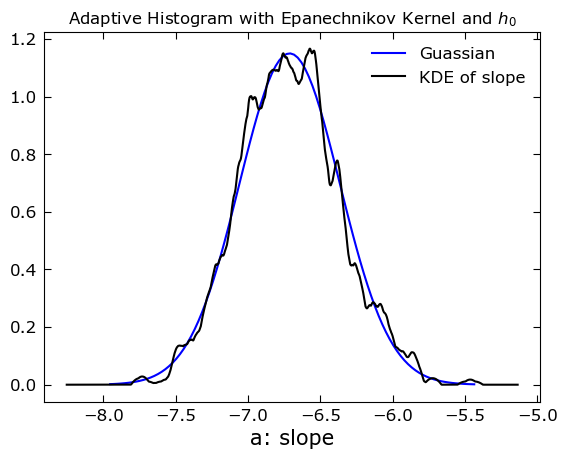

In [37]:
x_list = []
y_list = []
num_points = 1000

# loop over range of Fe/H from -3 to 1
for x in np.linspace(a_x[0] - 0.3, a_x[-1] + 0.3, int(num_points)):
    x_list.append(x)
    y_list.append(KDE_Epan_h(x, h_0_a, pboot[0]))

y_gaussian = []
for x in a_x:
    y_gaussian.append(gaussian(x, a_mu, a_sigma))
plt.plot(a_x, y_gaussian, color='b', label='Guassian')

plt.plot(x_list, y_list, color='k', label='KDE of slope')
plt.xlabel('a: slope')
# plt.ylabel('f(x)')
plt.title('Adaptive Histogram with Epanechnikov Kernel and $h_0$')
plt.legend()

Text(0.5, 1.0, 'Adaptive Histogram with Epanechnikov Kernel and $h_0$')

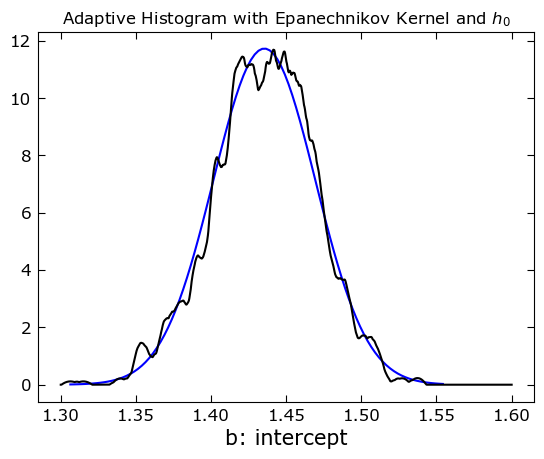

In [38]:
x_list = []
y_list = []
num_points = 1000

# loop over range of Fe/H from -3 to 1
for x in np.linspace(1.3, 1.6, int(num_points)):
    x_list.append(x)
    y_list.append(KDE_Epan_h(x, h_0_b, pboot[1]))

y_gaussian = []
for x in b_x:
    y_gaussian.append(gaussian(x, b_mu, b_sigma))
plt.plot(b_x, y_gaussian, color='b', label='Guassian')

plt.plot(x_list, y_list, color='k')
plt.xlabel('b: intercept')
# plt.ylabel('f(x)')
plt.title('Adaptive Histogram with Epanechnikov Kernel and $h_0$')

Text(0.5, 1.0, 'Adaptive Histogram with Epanechnikov Kernel and $h_0$')

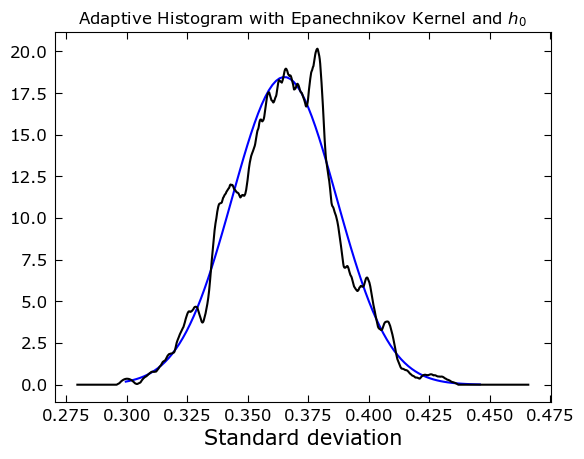

In [39]:
x_list = []
y_list = []
num_points = 1000

# loop over range of Fe/H from -3 to 1
for x in np.linspace(stdev_x[0] - 0.02, stdev_x[-1] + 0.02, int(num_points)):
    x_list.append(x)
    y_list.append(KDE_Epan_h(x, h_0_stdev, pboot[2]))

y_gaussian = []
for x in stdev_x:
    y_gaussian.append(gaussian(x, stdev_mu, stdev_sigma))
plt.plot(stdev_x, y_gaussian, color='b', label='Guassian')

plt.plot(x_list, y_list, color='k')
plt.xlabel('Standard deviation')
# plt.ylabel('f(x)')
plt.title('Adaptive Histogram with Epanechnikov Kernel and $h_0$')

I chose the Epanenchnikov kernel with the Silverman's rule (for h_0) because it is somewhat inbetween the top-hat and Gaussian kernels; or in other words, it's not too discrete, and not too smooth. If I were to use the Gaussian kernel, that would probably get rid of some details in the distribution that I want to see.

# 4. 
For each of the three model parameters, use the Kolmogorov-Smirnov test to determine whether the bootstrap samples are consistent with the above Gaussian distributions. What conclusion can you draw from the p-values?<br>

In [68]:
# print('a:', stats.kstest(pboot[0], gaussian(x, a_mu, a_sigma), args=(a_mu, a_sigma)))
print('a:', stats.kstest(pboot[0], 'norm', args=(a_mu, a_sigma)))
print('b:', stats.kstest(pboot[1], 'norm', args=(b_mu, b_sigma)))
print('stdev:', stats.kstest(pboot[2], 'norm', args=(stdev_mu, stdev_sigma)))

a: KstestResult(statistic=0.019763916477216537, pvalue=0.7756725121400182, statistic_location=-6.4860279133656125, statistic_sign=1)
b: KstestResult(statistic=0.02013412288598254, pvalue=0.7560388364025415, statistic_location=1.437114649591571, statistic_sign=-1)
stdev: KstestResult(statistic=0.0220008285060882, pvalue=0.6530586118677499, statistic_location=0.3810978280645609, statistic_sign=1)


These bootstrap samples are relatively consistent with Gaussian distributions, as the p-values are not below 0.05. Therefore, we cannot reject the null hypothesis that the samples are drawn from a Gaussian distribution. And visual inspection helps support this, as the overlain Gaussian distributions all look very similar in overall shape to the parameters' distributions.

# 5. 
Calculate the upper and lower confidence limits $dp_+$ and $dp_-$ for each model parameter $p = \{a,b,\sigma\}$, that is, the range 

$$ p^{+dp_+}_{-dp_-} $$ 

containing a given percentage (confidence level CL) of the bootstrap sample. Write a routine where CL is an argument. Calculate $dp_{\pm}$ for the 68.3% and 90% confidence levels. Compare the 68.3% CL with the standard deviations of the bootstrap sample.

In [77]:
def calculate_range(parameter_list, CL):
    mean = np.mean(parameter_list)
    closeness_to_mean = abs(parameter_list - mean)
    ordered_list = sorted(closeness_to_mean)
    max_of_range = CL * len(parameter_list)
    da = ordered_list[int(max_of_range)]
    return da

## a

In [118]:
da90 = calculate_range(pboot[0], 0.9)
da683 = calculate_range(pboot[0], 0.683)

print("90% confidence level a:", round(da90, 5))
print("68.3% confidence level a:", round(da683, 5))
print("a standard deviation a:", round(a_sigma, 5))

print("Relative error of CL and 1 std.:", round(abs(a_sigma - da683) / a_sigma * 100, 5), '%' )

90% confidence level a: 0.5848
68.3% confidence level a: 0.34467
a standard deviation a: 0.34701
Relative error of CL and 1 std.: 0.67375 %


## b

In [117]:
db90 = calculate_range(pboot[1], 0.9)
db683 = calculate_range(pboot[1], 0.683)

print("90% confidence level of b:", round(db90, 5))
print("68.3% confidence level of b:", round(db683, 5))
print("b standard deviation of b:", round(b_sigma, 5))

print("Relative error of CL and 1 std.:", round(abs(b_sigma - db683) / b_sigma * 100, 5), '%' )

90% confidence level of b: 0.05645
68.3% confidence level of b: 0.0332
b standard deviation of b: 0.03402
Relative error of CL and 1 std.: 2.39321 %


## $\sigma$

In [119]:
dstdev90 = calculate_range(pboot[2], 0.9)
dstdev683 = calculate_range(pboot[2], 0.683)

print("90% confidence level of sigma:", round(dstdev90, 5))
print("68.3% confidence level of sigma:", round(dstdev683, 5))
print("Standard deviation of sigma:", round(stdev_sigma, 5))

print("Relative error of CL and 1 std.:", round(abs(stdev_sigma - dstdev683) / stdev_sigma * 100, 5), '%' )

90% confidence level of sigma: 0.03632
68.3% confidence level of sigma: 0.02142
Standard deviation of sigma: 0.0216
Relative error of CL and 1 std.: 0.8487 %


## Comparing standard deviations and 68.3% confidence limit

In all of our parameters: a, b, and $\sigma$, all have very similar standard deviations compared to the calculated 68.3% confidence levels (all below 3% relative errors).

## Plot bootstrap distributions

Text(0.5, 0, 'a')

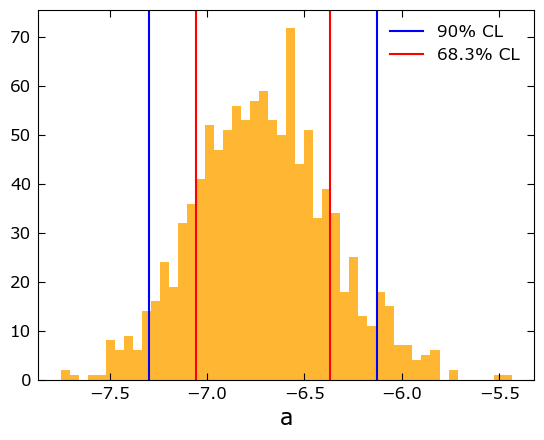

In [104]:
plt.hist(pboot[0], bins=50, color='orange', alpha=0.8)
plt.axvline(a_mu + da90, color='b', label='90% CL')
plt.axvline(a_mu - da90, color='b')
plt.axvline(a_mu + da683, color='r', label='68.3% CL')
plt.axvline(a_mu - da683, color='r')
plt.legend()
plt.xlabel('a', fontsize=16)

Text(0.5, 0, 'b')

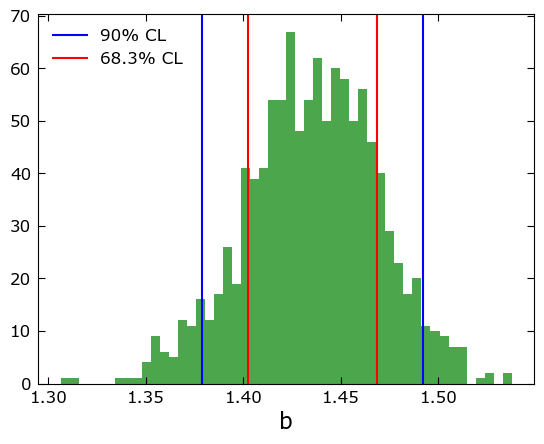

In [98]:
plt.hist(pboot[1], bins=50, color='g', alpha=0.7)
plt.axvline(b_mu + db90, color='b', label='90% CL')
plt.axvline(b_mu - db90, color='b')
plt.axvline(b_mu + db683, color='r', label='68.3% CL')
plt.axvline(b_mu - db683, color='r')
plt.legend()
plt.xlabel('b', fontsize=16)

Text(0.5, 0, '$\\sigma$')

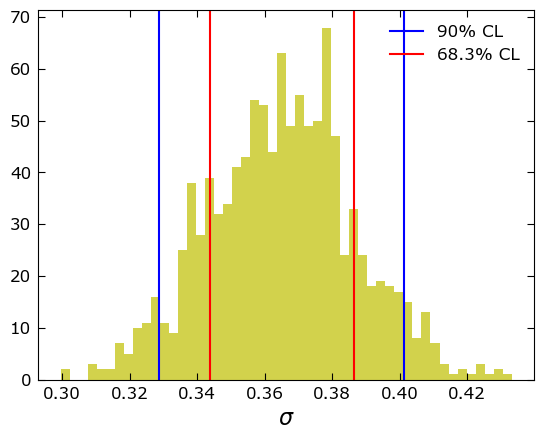

In [105]:
plt.hist(pboot[2], bins=50, color='y', alpha=0.7)
plt.axvline(stdev_mu + dstdev90, color='b', label='90% CL')
plt.axvline(stdev_mu - dstdev90, color='b')
plt.axvline(stdev_mu + dstdev683, color='r', label='68.3% CL')
plt.axvline(stdev_mu - dstdev683, color='r')
plt.legend()
plt.xlabel('$\sigma$', fontsize=16)

# Concluding assessment:

Numerical methods which worked or did not work in this project:
* The bootstrapping method worked to create distributions of the parameters we were fitting (a, b, and $\sigma$).
* The convergence criterion seemed to work well, as all three parameters converged within 1100 realizations.
* The KDE worked again as a visualization of the parameters' distributions.
* The Kolmogorov-Smirnov test seemed to do a good job at giving a value as to how well our distributions matched a normal distribution.
* The 68% confidence limits I calculated were all very similar to the standard deviation, which shows that those limits worked well.


Lessons learned:
* To use batches for bootstraping, instead of adding a single realization each time, for consistency.
* I learned that the results of the bootstrap (at least in this case, maybe not in others) were very close to a Gaussian distribution.
* That we can then find means and standard deviations on *each* parameters' bootstrapped distributions to get even more information about the parameters we fit for.


Further code improvements I could make with significantly more effort:
* I could have plotted internal convergence criteria to observe how the relative/absolute error changed with each realization.
* I could have found asymetric confidence limits.
* I could have tried to model the distributions and then found confidence limits based on those continuous functions, rather than the discrete distributions I used.